# HVAC Power Consumption Prediction in Electric Vehicles

## Main GOAL: To develop a highly accurate, real-time predictive model for the HVAC system's instantaneous power consumption in electric vehicles, utilizing a comprehensive,real-world dataset

### Notebook focusses on DATA PROCESSING

### Imports

In [1]:
# Suppress TensorFlow GPU warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warnings, 3=errors

# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Explainable AI (SHAP)
import shap

2025-09-17 04:41:43.138958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758084103.389046      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758084103.462881      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Input

In [2]:
TripA_clean = pd.read_csv('/kaggle/input/hvac-processeddata/TripA_clean.csv')
TripB_clean = pd.read_csv('/kaggle/input/hvac-processeddata/TripB_clean.csv')

In [3]:
TripA_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467701 entries, 0 to 467700
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      467701 non-null  int64  
 1   time                            467701 non-null  float64
 2   velocity                        467701 non-null  float64
 3   elevation                       467701 non-null  float64
 4   throttle                        467701 non-null  float64
 5   motor_torque                    467701 non-null  float64
 6   longitudinal_acceleration       467701 non-null  float64
 7   regenerative_braking_signal     467701 non-null  float64
 8   battery_voltage                 467701 non-null  float64
 9   battery_current                 467701 non-null  float64
 10  battery_temperature             467701 non-null  float64
 11  max_battery_temperature         467701 non-null  float64
 12  soc             

In [4]:
TripB_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627092 entries, 0 to 627091
Data columns (total 53 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         627092 non-null  int64  
 1   time                               627092 non-null  float64
 2   velocity                           627092 non-null  float64
 3   elevation                          627092 non-null  float64
 4   throttle                           627092 non-null  float64
 5   motor_torque                       627092 non-null  float64
 6   longitudinal_acceleration          627092 non-null  float64
 7   regenerative_braking_signal        627092 non-null  float64
 8   battery_voltage                    627092 non-null  float64
 9   battery_current                    627092 non-null  float64
 10  battery_temperature                627092 non-null  float64
 11  max_battery_temperature            6270

### Features and Target
TripA (summer): Predict AirCon Power
TripB (winter): Predict Heating Power

In [5]:
features_A = [
    'velocity', 'longitudinal_acceleration', 'motor_torque', 'elevation',
    'battery_voltage', 'battery_current', 'battery_power',
    'ambient_temperature', 'cabin_temperature_sensor', 'cabin_ambient_delta',
    'requested_heating_power_prev', 'aircon_power_prev', 'heating_power_can_prev'
]

target_A = 'aircon_power'

X_A = TripA_clean[features_A].values
y_A = TripA_clean[target_A].values


In [6]:
features_B = [
    'velocity', 'longitudinal_acceleration', 'motor_torque', 'elevation',
    'battery_voltage', 'battery_current', 'battery_power',
    'ambient_temperature', 'cabin_temperature_sensor', 'cabin_ambient_delta',
    'requested_heating_power_prev', 'aircon_power_prev', 'heating_power_can_prev'
]

target_B = 'hvac_target_power'  # for heating

X_B = TripB_clean[features_B].values
y_B = TripB_clean[target_B].values

### Feature Scaling

In [7]:
scaler_A = StandardScaler()
X_A_scaled = scaler_A.fit_transform(X_A)

scaler_B = StandardScaler()
X_B_scaled = scaler_B.fit_transform(X_B)

### Create LSTM Sequences

In [8]:
def create_sequences(X, y, time_steps=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 30

# TripA
X_A_seq, y_A_seq = create_sequences(X_A_scaled, y_A, time_steps)
split_A = int(len(X_A_seq) * 0.8)
X_A_train, X_A_test = X_A_seq[:split_A], X_A_seq[split_A:]
y_A_train, y_A_test = y_A_seq[:split_A], y_A_seq[split_A:]

# TripB
X_B_seq, y_B_seq = create_sequences(X_B_scaled, y_B, time_steps)
split_B = int(len(X_B_seq) * 0.8)
X_B_train, X_B_test = X_B_seq[:split_B], X_B_seq[split_B:]
y_B_train, y_B_test = y_B_seq[:split_B], y_B_seq[split_B:]


### Build LSTM Model

In [9]:
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_A = build_lstm((X_A_train.shape[1], X_A_train.shape[2]))
model_B = build_lstm((X_B_train.shape[1], X_B_train.shape[2]))

2025-09-17 04:42:19.204103: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


### Train Models with LSTM

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

batch_size = 128  # adjustable
epochs = 100      # max epochs; training stops early if no improvement

# TripA
history_A = model_A.fit(
    X_A_train, y_A_train,
    validation_data=(X_A_test, y_A_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

# TripB
history_B = model_B.fit(
    X_B_train, y_B_train,
    validation_data=(X_B_test, y_B_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 94s 31ms/step - loss: 0.0170 - mae: 0.0650 - val_loss: 0.0011 - val_mae: 0.0172
Epoch 2/100
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - loss: 0.0017 - mae: 0.0207 - val_loss: 0.0023 - val_mae: 0.0248
Epoch 3/100
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - loss: 0.0014 - mae: 0.0173 - val_loss: 0.0026 - val_mae: 0.0272
Epoch 4/100
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 89s 31ms/step - loss: 0.0012 - mae: 0.0151 - val_loss: 0.0059 - val_mae: 0.0392
Epoch 5/100
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 89s 30ms/step - loss: 9.9817e-04 - mae: 0.0132 - val_loss: 0.0086 - val_mae: 0.0480
Epoch 6/100
2923/2923 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - loss: 9.7677e-04 - mae: 0.0119 - val_loss: 0.0073 - val_mae: 0.0457
Epoch 1/100
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 128s 32ms/step - loss: 0.5144 - mae: 0.2282 - val_loss: 0.0040 - val_mae: 0.0332
Epoch 2/100
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 121s 31ms/step - loss: 0.0608 - mae: 0.0768 - val_loss: 0.0061 - val_mae: 0.0612
Epoch 

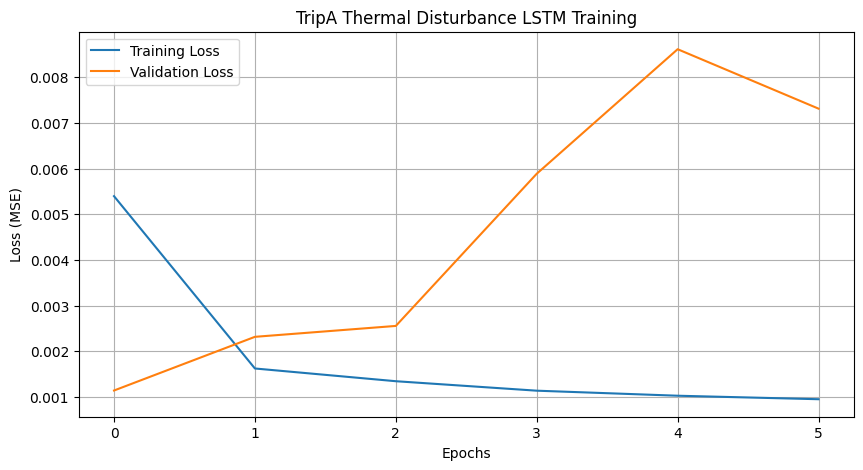

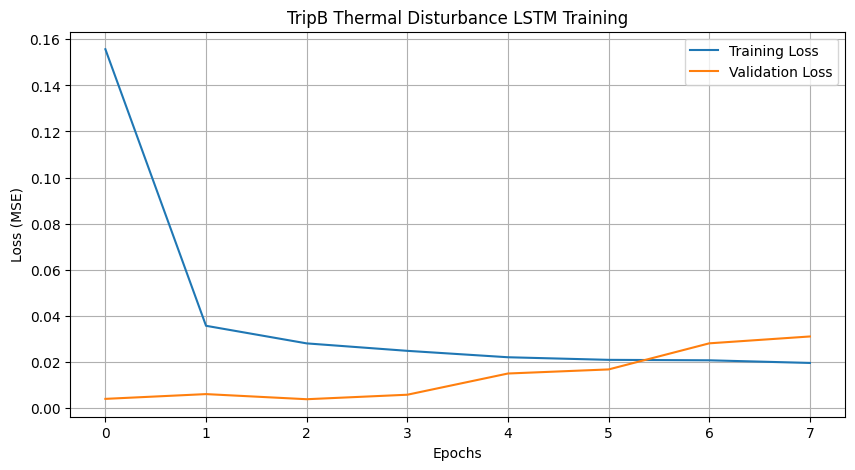

In [11]:
def plot_training_history(history, title=''):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# TripA
plot_training_history(history_A, title='TripA Thermal Disturbance LSTM Training')

# TripB
plot_training_history(history_B, title='TripB Thermal Disturbance LSTM Training')

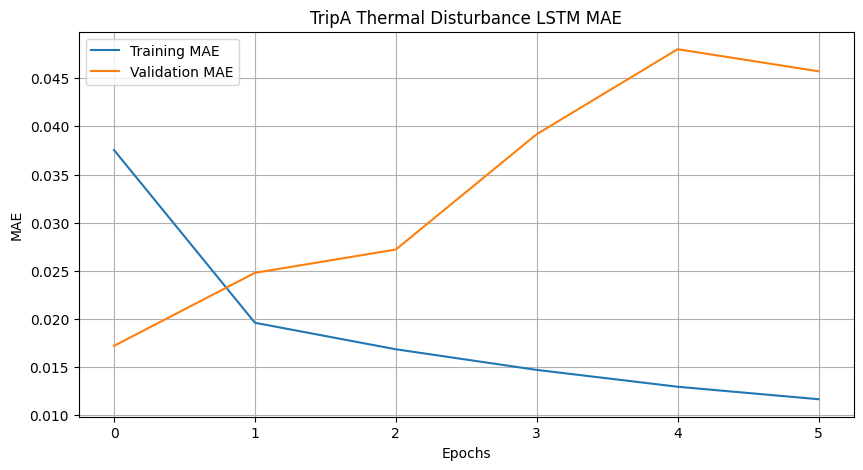

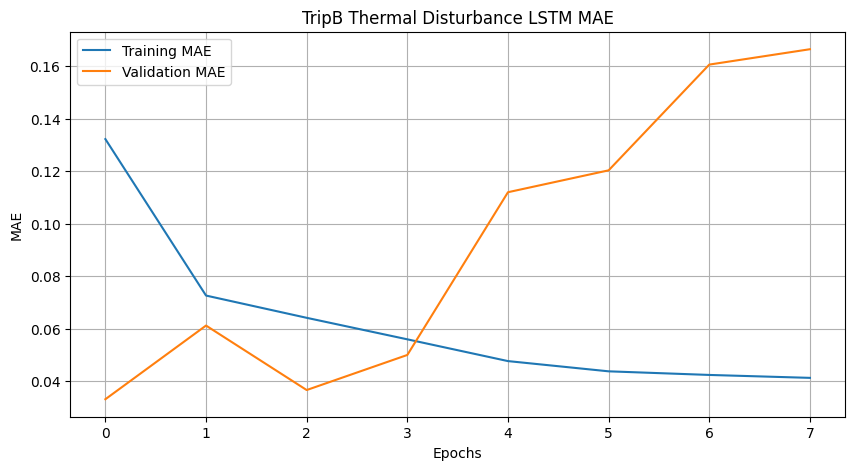

In [12]:
def plot_mae_history(history, title=''):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# TripA
plot_mae_history(history_A, title='TripA Thermal Disturbance LSTM MAE')

# TripB
plot_mae_history(history_B, title='TripB Thermal Disturbance LSTM MAE')

### Predict Thermal Disturbances

In [13]:
y_A_pred = model_A.predict(X_A_test)
y_B_pred = model_B.predict(X_B_test)

2923/2923 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step


In [14]:
# TripA
thermal_pred_A = pd.DataFrame({
    'time': TripA_clean['time'].iloc[-len(y_A_pred):].values,
    'cabin_ambient_delta_true': y_A_test,
    'cabin_ambient_delta_pred': y_A_pred.flatten()
})
thermal_pred_A.to_csv('/kaggle/working/TripA_thermal_pred.csv', index=False)

# TripB
thermal_pred_B = pd.DataFrame({
    'time': TripB_clean['time'].iloc[-len(y_B_pred):].values,
    'cabin_ambient_delta_true': y_B_test,
    'cabin_ambient_delta_pred': y_B_pred.flatten()
})
thermal_pred_B.to_csv('/kaggle/working/TripB_thermal_pred.csv', index=False)


### Evaluate Models

In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return y_pred

# TripA
y_A_pred = evaluate_model(model_A, X_A_test, y_A_test)

# TripB
y_B_pred = evaluate_model(model_B, X_B_test, y_B_test)

2923/2923 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step
MAE: 0.0172, RMSE: 0.0338, R2: 0.9963
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
MAE: 0.0367, RMSE: 0.0620, R2: 0.9954


### Visualize Predictions

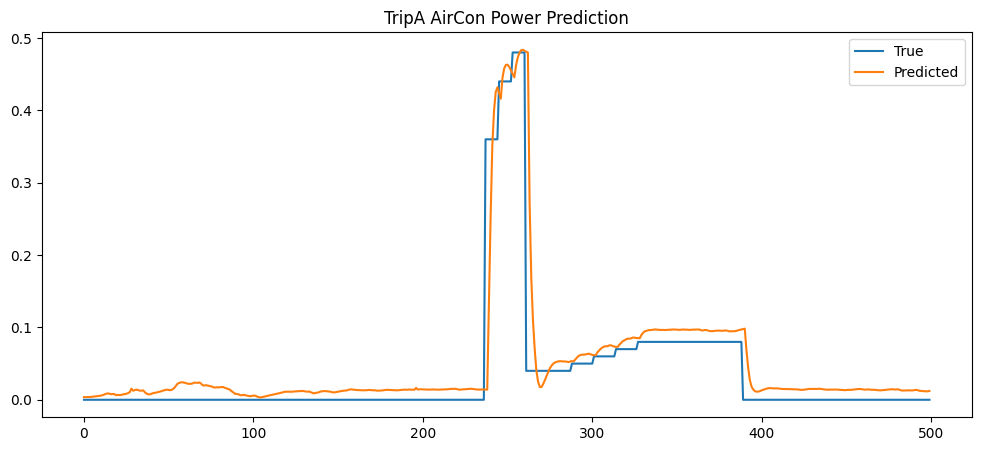

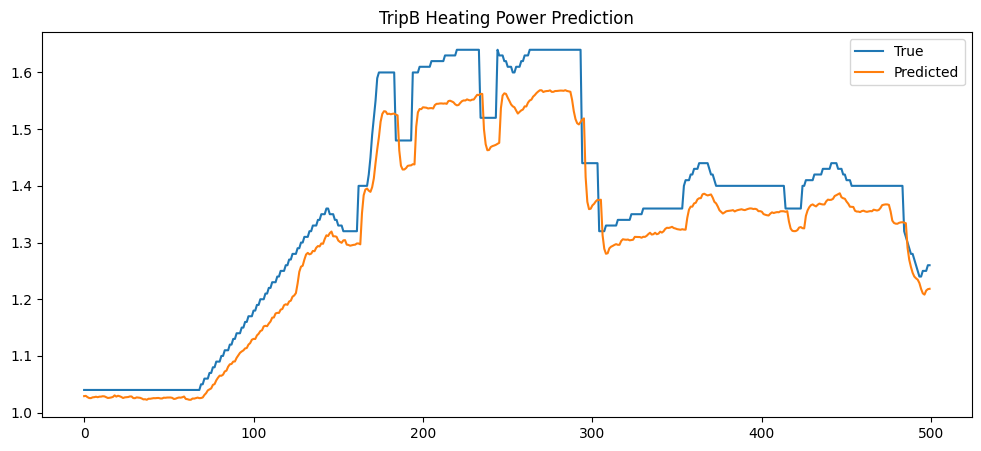

In [16]:
def plot_predictions(y_true, y_pred, n=500, title=''):
    plt.figure(figsize=(12,5))
    plt.plot(y_true[:n], label='True')
    plt.plot(y_pred[:n], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_predictions(y_A_test, y_A_pred, title='TripA AirCon Power Prediction')
plot_predictions(y_B_test, y_B_pred, title='TripB Heating Power Prediction')